In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
import sys
sys.path.insert(0, '../src')

## 3. Modeling - XGBoost

### 3.1 Load and Explore Dataset

**[3.1.1]** Import the pandas, numpy, and dump package

In [2]:
import pandas as pd
import numpy as np
from joblib import dump

In [3]:
X_train = pd.read_csv('../data/processed/X_train.csv')
X_val = pd.read_csv('../data/processed/X_val.csv')
y_train = pd.read_csv('../data/processed/y_train.csv')
y_val = pd.read_csv('../data/processed/y_val.csv')
X_test = pd.read_csv('../data/processed/X_test.csv')

In [4]:
y_train = y_train.values.ravel()
y_val = y_val.values.ravel()

### 3.3 XGBoost

In [30]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

Fit the model without hyperparameter tuning.

In [6]:
xgboost = XGBClassifier(objective='binary:logistic', random_state=8)
xgboost.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=8, ...)

In [8]:
from models.predict_model import Modeling

In [9]:
modeling = Modeling(xgboost, X_train, X_val, y_train, y_val, X_test)

                roc-auc score  accuracy score  precision score  recall score   
Training Set         1.000000        1.000000         1.000000      1.000000  \
Validation Set       0.999981        0.997466         0.995457      0.999493   

                f1 score  
Training Set    1.000000  
Validation Set  0.997471  


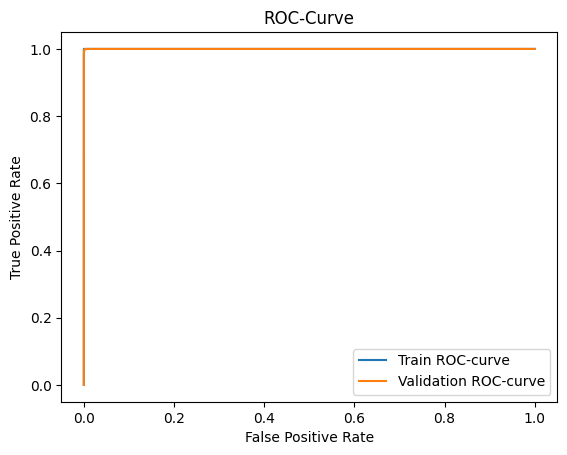

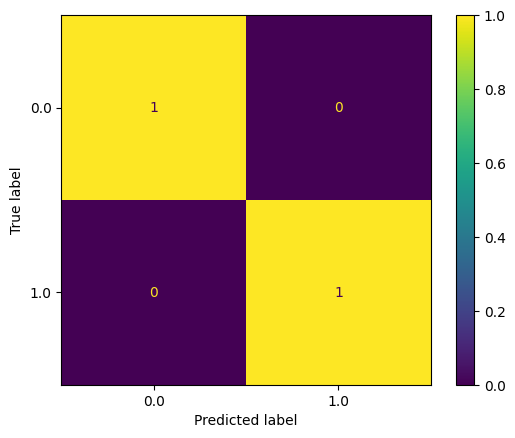

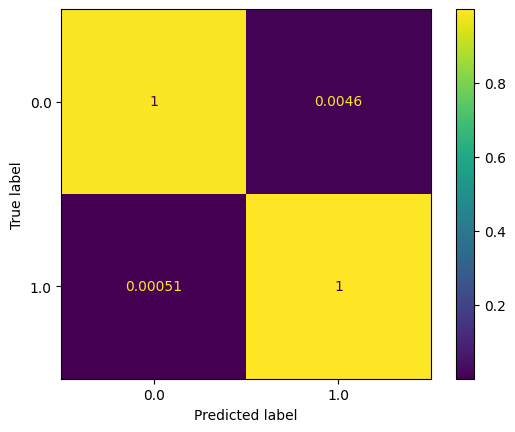

In [10]:
modeling.predict_model()

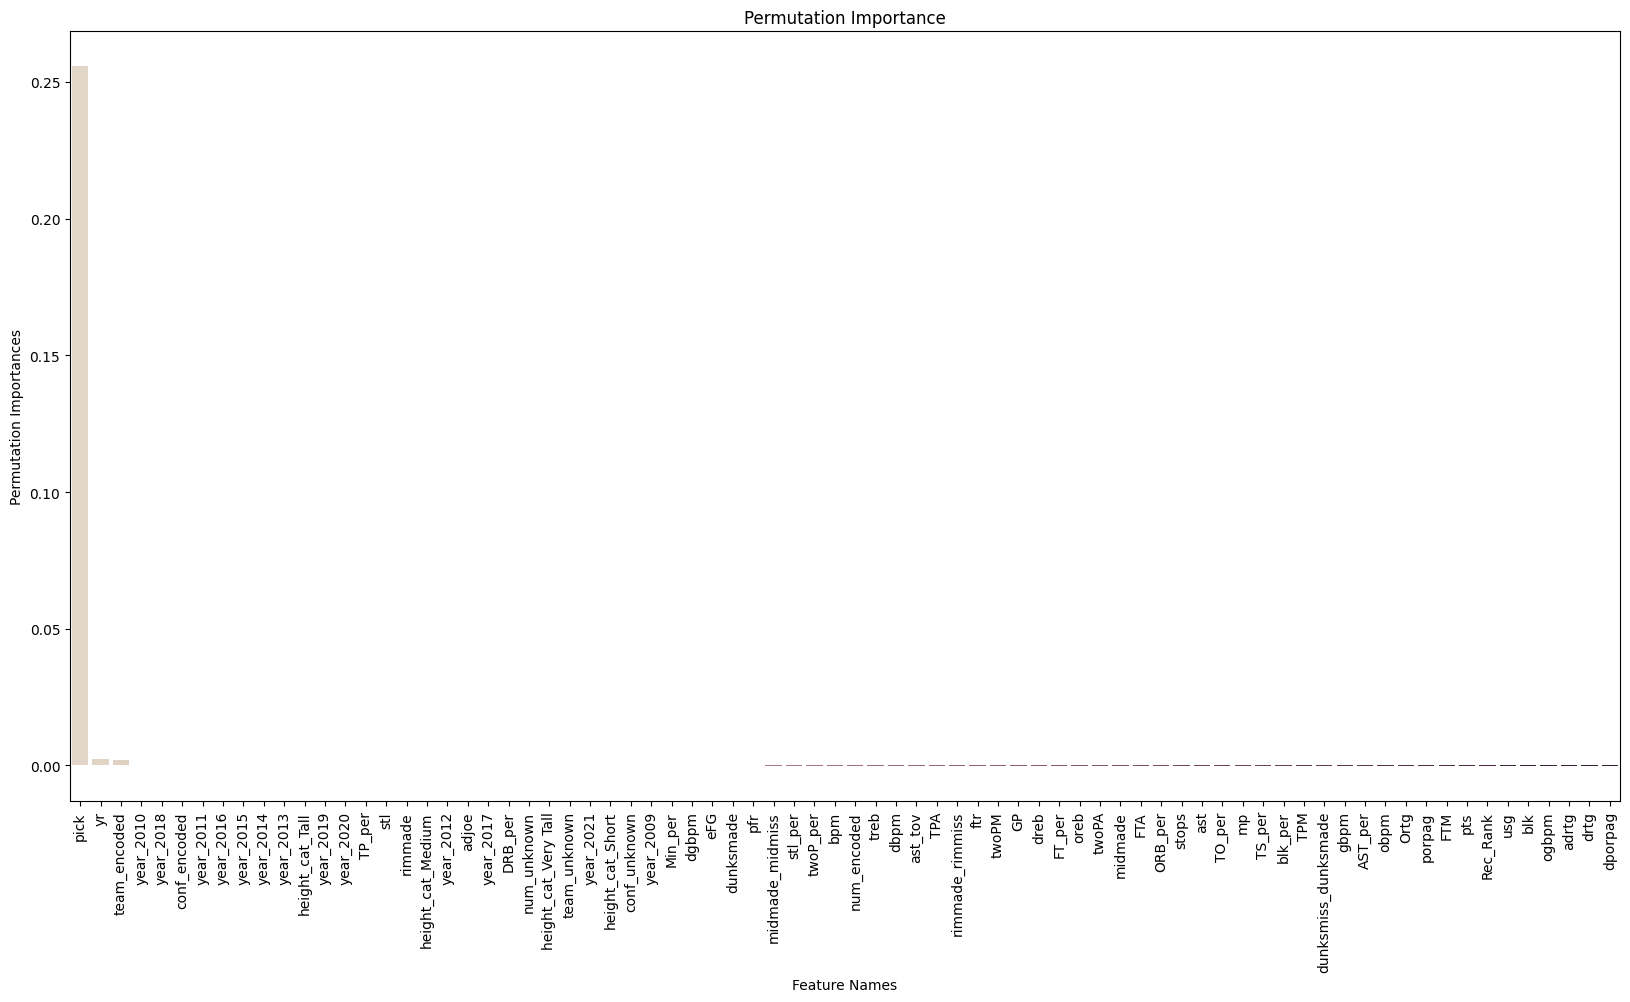

In [12]:
permunation_score = modeling.permutation_importance()

In [34]:
from joblib import dump

dump(xgboost, '../models/xgboost.joblib')

['../models/xgboost.joblib']

In [15]:
from visualization.submission_file import submission_file

In [13]:
y_test_probs = xgboost.predict_proba(X_test)[:, 1]

In [16]:
submission_3 = submission_file(y_test_probs)

In [47]:
submission_3.to_csv('../data/submission/submission_1_xgboost.csv', index=False)

#### Hyperparameter Tuning with learning rate

In [33]:
learning_rate = [0.01, 0.1, 0.3]

train_auc_score = []
val_auc_score = []
train_accuracy = []
val_accuracy = []
train_recall = []
val_recall = []
train_precision = []
val_precision = []
train_f1_score = []
val_f1_score = []

for i in learning_rate:
    xgboost = XGBClassifier(random_state=8, objective='binary:logistic', learning_rate=i).fit(X_train, y_train)
    y_train_preds = xgboost.predict(X_train)
    y_val_preds = xgboost.predict(X_val)
    
    y_train_probs = xgboost.predict_proba(X_train)[:, 1]
    y_val_probs = xgboost.predict_proba(X_val)[:, 1]

    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    val_accuracy.append(accuracy_score(y_val, y_val_preds))

    train_recall.append(recall_score(y_train, y_train_preds))
    val_recall.append(recall_score(y_val, y_val_preds))

    train_precision.append(precision_score(y_train, y_train_preds))
    val_precision.append(precision_score(y_val, y_val_preds))

    train_f1_score.append(f1_score(y_train, y_train_preds))
    val_f1_score.append(f1_score(y_val, y_val_preds))
    
    train_auc_score.append(roc_auc_score(y_train, y_train_probs))
    val_auc_score.append(roc_auc_score(y_val, y_val_probs))
    
results_learning_rate = pd.DataFrame({'train_auc_score': train_auc_score,
                          'val_auc_score': val_auc_score,
                          'train_accuracy': train_accuracy,
                          'val_accuracy': val_accuracy,
                          'train_precision': train_precision,
                          'val_precision': val_precision,
                          'train_recall': train_recall,
                          'val_recall': val_recall,
                          'train_f1_score': train_f1_score,
                          'val_f1_score': val_f1_score}, index=learning_rate)
results_learning_rate

,train_auc_score,val_auc_score,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1_score,val_f1_score
0.01,0.998581,0.998409,0.994653,0.994324,0.989420,0.988873,1.000000,0.999899,0.994682,0.994355
0.10,1.000000,0.999956,0.999658,0.997263,0.999342,0.994856,0.999975,0.999696,0.999658,0.997270
0.30,1.000000,0.999981,1.000000,0.997466,1.000000,0.995457,1.000000,0.999493,1.000000,0.997471


In [34]:
def plot_performance(parameter, xlabel):

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 5))

    ax1.plot(parameter, val_accuracy, label='Validation Accuracy')
    ax1.plot(parameter, train_accuracy, label='Training Accuracy')
    ax1.legend()
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Accuracy Score')

    ax2.plot(parameter, val_precision, label='Validation Precision')
    ax2.plot(parameter, train_precision, label='Training Precision')
    ax2.legend()
    ax2.set_xlabel(xlabel)
    ax2.set_ylabel('Precision')
    ax2.set_title('Precision Score')

    ax3.plot(parameter, val_recall, label='Validation Recall')
    ax3.plot(parameter, train_recall, label='Training Recall')
    ax3.legend()
    ax3.set_xlabel(xlabel)
    ax3.set_ylabel('Recall')
    ax3.set_title('Recall Score')

    ax4.plot(parameter, val_f1_score, label='Validation F1-Score')
    ax4.plot(parameter, train_f1_score, label='Training F1-Score')
    ax4.legend()
    ax4.set_xlabel(xlabel)
    ax4.set_ylabel('F1-Score')
    ax4.set_title('F1-Score')
    
    plt.subplots_adjust(wspace=0.4)
    plt.show()

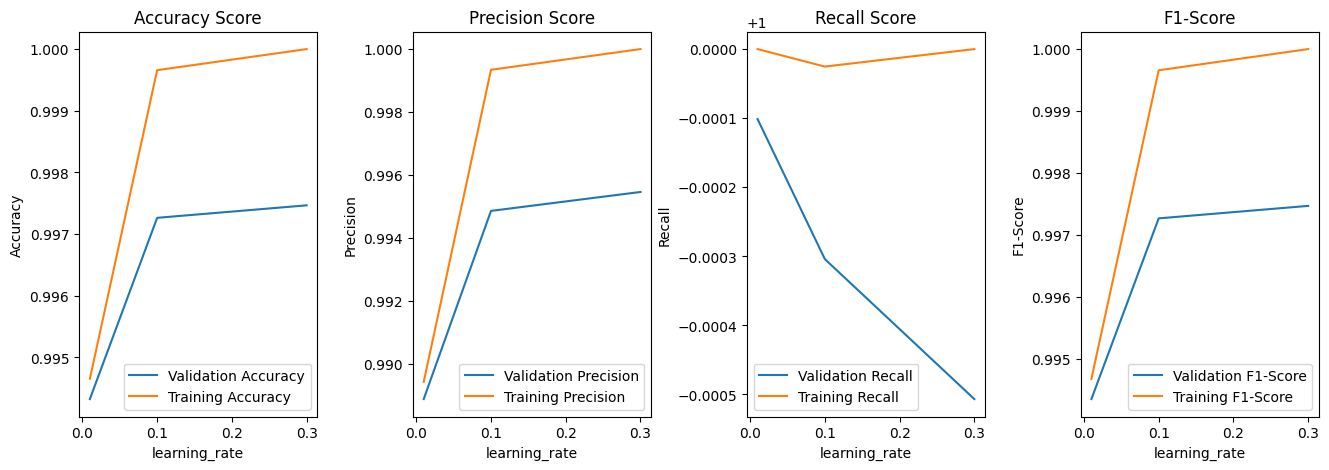

In [35]:
plot_performance(learning_rate, 'learning_rate')

#### Hyperparameter Tuning with n_estimators

default = 100

In [36]:
n_estimators = [100, 300, 500, 700, 900]

train_auc_score = []
val_auc_score = []
train_accuracy = []
val_accuracy = []
train_recall = []
val_recall = []
train_precision = []
val_precision = []
train_f1_score = []
val_f1_score = []

learning_rate = 0.01

for i in n_estimators:
    xgboost = XGBClassifier(random_state=8, objective='binary:logistic', learning_rate=0.01, n_estimators=i).fit(X_train, y_train)
    y_train_preds = xgboost.predict(X_train)
    y_val_preds = xgboost.predict(X_val)
    
    y_train_probs = xgboost.predict_proba(X_train)[:, 1]
    y_val_probs = xgboost.predict_proba(X_val)[:, 1]

    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    val_accuracy.append(accuracy_score(y_val, y_val_preds))

    train_recall.append(recall_score(y_train, y_train_preds))
    val_recall.append(recall_score(y_val, y_val_preds))

    train_precision.append(precision_score(y_train, y_train_preds))
    val_precision.append(precision_score(y_val, y_val_preds))

    train_f1_score.append(f1_score(y_train, y_train_preds))
    val_f1_score.append(f1_score(y_val, y_val_preds))
    
    train_auc_score.append(roc_auc_score(y_train, y_train_probs))
    val_auc_score.append(roc_auc_score(y_val, y_val_probs))
    
results_n_estimators = pd.DataFrame({'train_auc_score': train_auc_score,
                          'val_auc_score': val_auc_score,
                          'train_accuracy': train_accuracy,
                          'val_accuracy': val_accuracy,
                          'train_precision': train_precision,
                          'val_precision': val_precision,
                          'train_recall': train_recall,
                          'val_recall': val_recall,
                          'train_f1_score': train_f1_score,
                          'val_f1_score': val_f1_score}, index=n_estimators)
results_n_estimators

,train_auc_score,val_auc_score,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1_score,val_f1_score
100,0.998581,0.998409,0.994653,0.994324,0.989420,0.988873,1.000000,0.999899,0.994682,0.994355
300,0.999855,0.999571,0.995895,0.994831,0.991857,0.989767,1.000000,1.000000,0.995912,0.994857
500,0.999992,0.999907,0.997238,0.995946,0.994506,0.992056,1.000000,0.999899,0.997246,0.995962
700,0.999998,0.999923,0.998353,0.996402,0.996742,0.992954,0.999975,0.999899,0.998356,0.996414
900,1.000000,0.999953,0.999290,0.997111,0.998608,0.994355,0.999975,0.999899,0.999291,0.997119


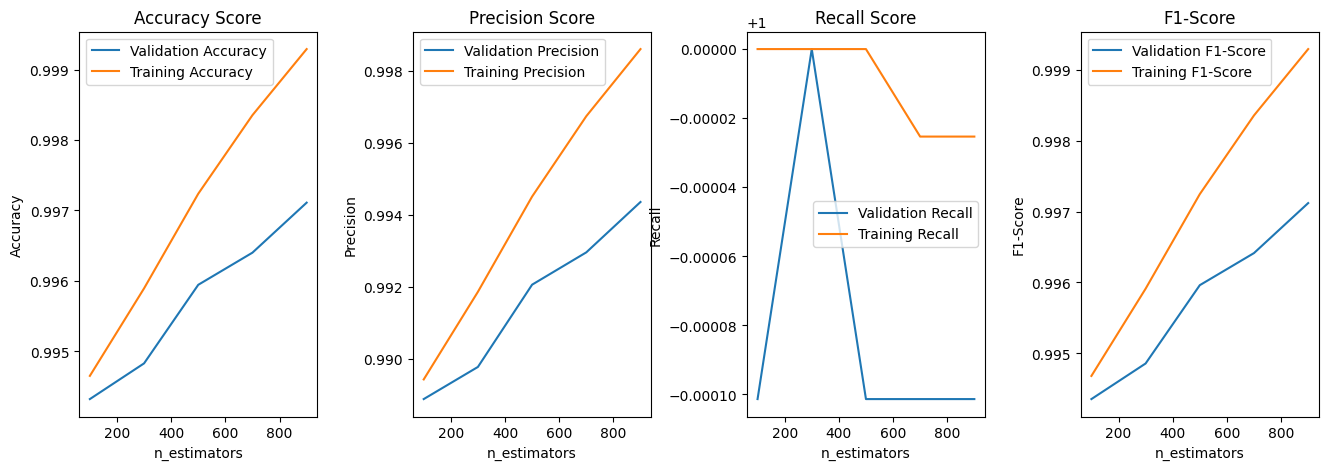

In [37]:
plot_performance(n_estimators, 'n_estimators')

#### Hyperparameter Tuning with Max Depth

In [39]:
max_depth = [3, 5, 7, 9]

train_auc_score = []
val_auc_score = []
train_accuracy = []
val_accuracy = []
train_recall = []
val_recall = []
train_precision = []
val_precision = []
train_f1_score = []
val_f1_score = []

learning_rate = 0.01
n_estimators = 300

for i in max_depth:
    xgboost = XGBClassifier(random_state=8, objective='binary:logistic', learning_rate=learning_rate, n_estimators=n_estimators, max_depth=i).fit(X_train, y_train)
    y_train_preds = xgboost.predict(X_train)
    y_val_preds = xgboost.predict(X_val)
    
    y_train_probs = xgboost.predict_proba(X_train)[:, 1]
    y_val_probs = xgboost.predict_proba(X_val)[:, 1]

    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    val_accuracy.append(accuracy_score(y_val, y_val_preds))

    train_recall.append(recall_score(y_train, y_train_preds))
    val_recall.append(recall_score(y_val, y_val_preds))

    train_precision.append(precision_score(y_train, y_train_preds))
    val_precision.append(precision_score(y_val, y_val_preds))

    train_f1_score.append(f1_score(y_train, y_train_preds))
    val_f1_score.append(f1_score(y_val, y_val_preds))
    
    train_auc_score.append(roc_auc_score(y_train, y_train_probs))
    val_auc_score.append(roc_auc_score(y_val, y_val_probs))
    
results_max_depth = pd.DataFrame({'train_auc_score': train_auc_score,
                          'val_auc_score': val_auc_score,
                          'train_accuracy': train_accuracy,
                          'val_accuracy': val_accuracy,
                          'train_precision': train_precision,
                          'val_precision': val_precision,
                          'train_recall': train_recall,
                          'val_recall': val_recall,
                          'train_f1_score': train_f1_score,
                          'val_f1_score': val_f1_score}, index=max_depth)
results_max_depth

,train_auc_score,val_auc_score,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1_score,val_f1_score
3,0.998835,0.998620,0.993526,0.993665,0.987217,0.987489,1.0,1.0,0.993567,0.993705
5,0.999639,0.999326,0.995262,0.994679,0.990612,0.989469,1.0,1.0,0.995284,0.994707
7,0.999931,0.999759,0.996541,0.995236,0.993130,0.990562,1.0,1.0,0.996553,0.995259
9,0.999977,0.999924,0.997783,0.995895,0.995585,0.991857,1.0,1.0,0.997788,0.995912


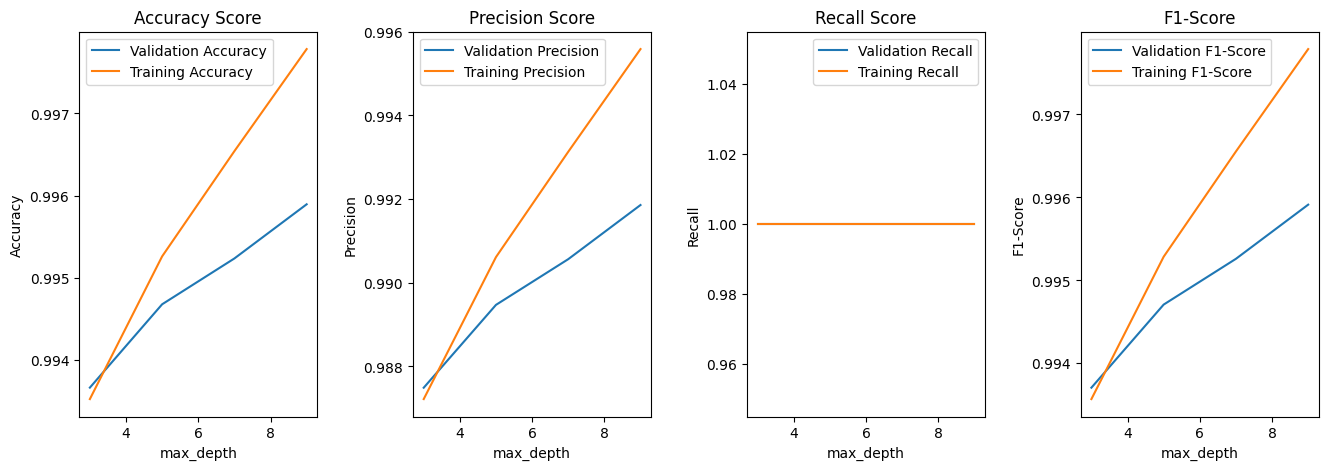

In [40]:
plot_performance(max_depth, 'max_depth')

#### Hyperparameter Tuning with subsample

In [42]:
subsample = [0.8, 0.9, 1.0]

train_auc_score = []
val_auc_score = []
train_accuracy = []
val_accuracy = []
train_recall = []
val_recall = []
train_precision = []
val_precision = []
train_f1_score = []
val_f1_score = []

learning_rate = 0.01
n_estimators = 300
max_depth = 5

for i in subsample:
    xgboost = XGBClassifier(random_state=8, objective='binary:logistic', learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth, subsample=i).fit(X_train, y_train)
    y_train_preds = xgboost.predict(X_train)
    y_val_preds = xgboost.predict(X_val)
    
    y_train_probs = xgboost.predict_proba(X_train)[:, 1]
    y_val_probs = xgboost.predict_proba(X_val)[:, 1]

    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    val_accuracy.append(accuracy_score(y_val, y_val_preds))

    train_recall.append(recall_score(y_train, y_train_preds))
    val_recall.append(recall_score(y_val, y_val_preds))

    train_precision.append(precision_score(y_train, y_train_preds))
    val_precision.append(precision_score(y_val, y_val_preds))

    train_f1_score.append(f1_score(y_train, y_train_preds))
    val_f1_score.append(f1_score(y_val, y_val_preds))
    
    train_auc_score.append(roc_auc_score(y_train, y_train_probs))
    val_auc_score.append(roc_auc_score(y_val, y_val_probs))
    
results_subsample = pd.DataFrame({'train_auc_score': train_auc_score,
                          'val_auc_score': val_auc_score,
                          'train_accuracy': train_accuracy,
                          'val_accuracy': val_accuracy,
                          'train_precision': train_precision,
                          'val_precision': val_precision,
                          'train_recall': train_recall,
                          'val_recall': val_recall,
                          'train_f1_score': train_f1_score,
                          'val_f1_score': val_f1_score}, index=subsample)
results_subsample

,train_auc_score,val_auc_score,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1_score,val_f1_score
0.8,0.999778,0.999574,0.995236,0.994679,0.990562,0.989469,1.0,1.0,0.995259,0.994707
0.9,0.999762,0.999549,0.995287,0.994729,0.990662,0.989569,1.0,1.0,0.995309,0.994757
1.0,0.999639,0.999326,0.995262,0.994679,0.990612,0.989469,1.0,1.0,0.995284,0.994707


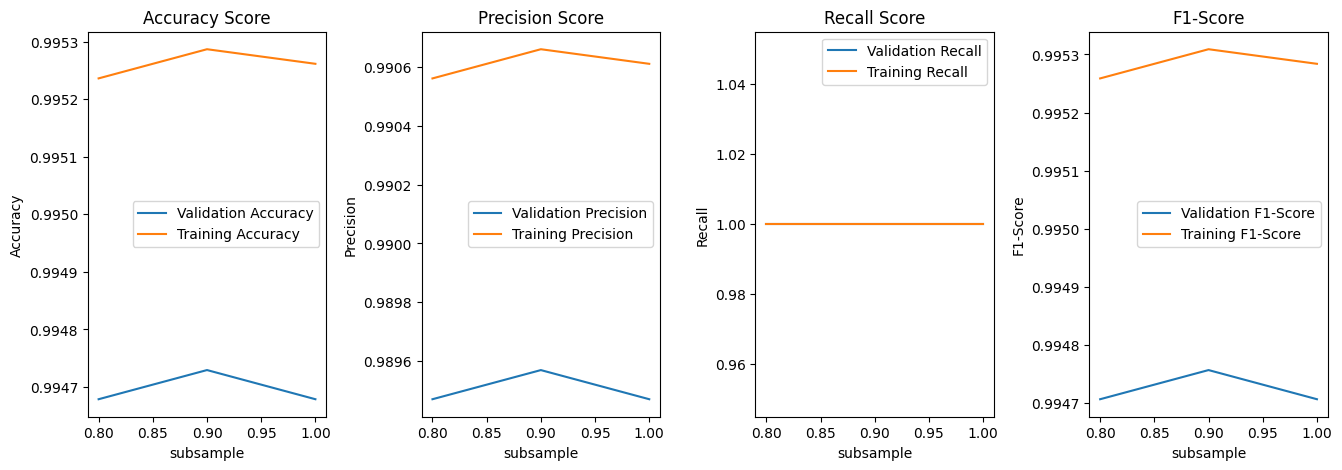

In [43]:
plot_performance(subsample, 'subsample')

In [44]:
colsample_bytree = [0.8, 0.9, 1.0]

train_auc_score = []
val_auc_score = []
train_accuracy = []
val_accuracy = []
train_recall = []
val_recall = []
train_precision = []
val_precision = []
train_f1_score = []
val_f1_score = []

learning_rate = 0.01
n_estimators = 300
max_depth = 5
subsample = 0.9

for i in colsample_bytree:
    xgboost = XGBClassifier(random_state=8, objective='binary:logistic', learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth, subsample=subsample, colsample_bytree=i).fit(X_train, y_train)
    y_train_preds = xgboost.predict(X_train)
    y_val_preds = xgboost.predict(X_val)
    
    y_train_probs = xgboost.predict_proba(X_train)[:, 1]
    y_val_probs = xgboost.predict_proba(X_val)[:, 1]

    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    val_accuracy.append(accuracy_score(y_val, y_val_preds))

    train_recall.append(recall_score(y_train, y_train_preds))
    val_recall.append(recall_score(y_val, y_val_preds))

    train_precision.append(precision_score(y_train, y_train_preds))
    val_precision.append(precision_score(y_val, y_val_preds))

    train_f1_score.append(f1_score(y_train, y_train_preds))
    val_f1_score.append(f1_score(y_val, y_val_preds))
    
    train_auc_score.append(roc_auc_score(y_train, y_train_probs))
    val_auc_score.append(roc_auc_score(y_val, y_val_probs))
    
results_colsample = pd.DataFrame({'train_auc_score': train_auc_score,
                          'val_auc_score': val_auc_score,
                          'train_accuracy': train_accuracy,
                          'val_accuracy': val_accuracy,
                          'train_precision': train_precision,
                          'val_precision': val_precision,
                          'train_recall': train_recall,
                          'val_recall': val_recall,
                          'train_f1_score': train_f1_score,
                          'val_f1_score': val_f1_score}, index=colsample_bytree)
results_colsample

,train_auc_score,val_auc_score,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1_score,val_f1_score
0.8,0.999745,0.999569,0.995059,0.994729,0.990214,0.989569,1.0,1.0,0.995083,0.994757
0.9,0.999739,0.999551,0.995211,0.994729,0.990513,0.989569,1.0,1.0,0.995234,0.994757
1.0,0.999762,0.999549,0.995287,0.994729,0.990662,0.989569,1.0,1.0,0.995309,0.994757


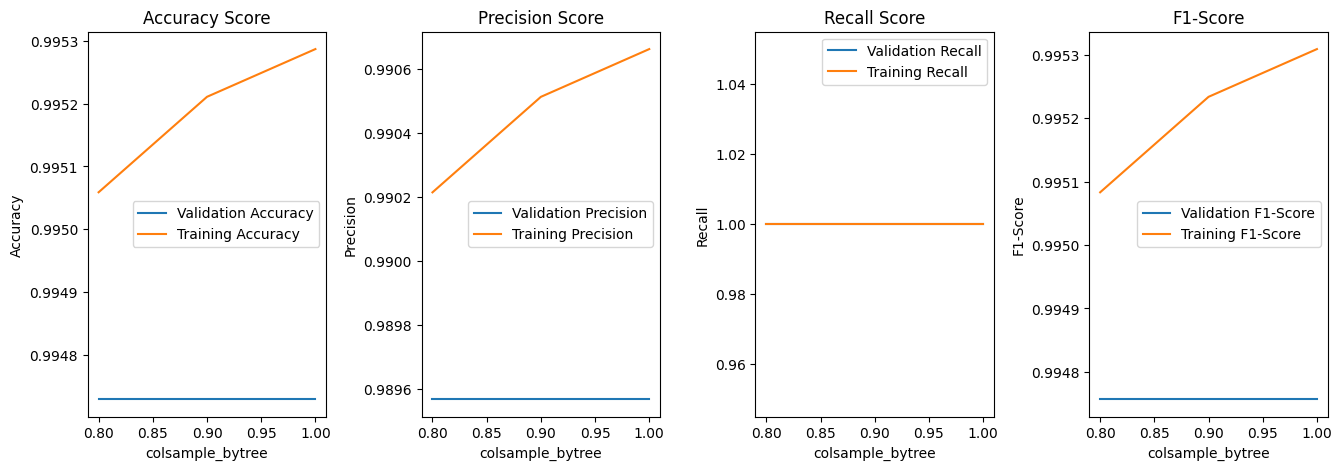

In [45]:
plot_performance(colsample_bytree, 'colsample_bytree')

#### Hyperparameter Tuning with gamma

In [49]:
gamma = [0, 0.1, 0.2, 0.3]

train_auc_score = []
val_auc_score = []
train_accuracy = []
val_accuracy = []
train_recall = []
val_recall = []
train_precision = []
val_precision = []
train_f1_score = []
val_f1_score = []

learning_rate = 0.01
n_estimators = 300
max_depth = 5
subsample = 0.9
colsample_bytree = 0.8
 

for i in gamma:
    xgboost = XGBClassifier(random_state=8, objective='binary:logistic', learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth, subsample=subsample, colsample_bytree=colsample_bytree, gamma=i).fit(X_train, y_train)
    y_train_preds = xgboost.predict(X_train)
    y_val_preds = xgboost.predict(X_val)
    
    y_train_probs = xgboost.predict_proba(X_train)[:, 1]
    y_val_probs = xgboost.predict_proba(X_val)[:, 1]

    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    val_accuracy.append(accuracy_score(y_val, y_val_preds))

    train_recall.append(recall_score(y_train, y_train_preds))
    val_recall.append(recall_score(y_val, y_val_preds))

    train_precision.append(precision_score(y_train, y_train_preds))
    val_precision.append(precision_score(y_val, y_val_preds))

    train_f1_score.append(f1_score(y_train, y_train_preds))
    val_f1_score.append(f1_score(y_val, y_val_preds))
    
    train_auc_score.append(roc_auc_score(y_train, y_train_probs))
    val_auc_score.append(roc_auc_score(y_val, y_val_probs))
    
results_gamma = pd.DataFrame({'train_auc_score': train_auc_score,
                          'val_auc_score': val_auc_score,
                          'train_accuracy': train_accuracy,
                          'val_accuracy': val_accuracy,
                          'train_precision': train_precision,
                          'val_precision': val_precision,
                          'train_recall': train_recall,
                          'val_recall': val_recall,
                          'train_f1_score': train_f1_score,
                          'val_f1_score': val_f1_score}, index=gamma)
results_gamma

,train_auc_score,val_auc_score,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1_score,val_f1_score
0.0,0.999745,0.999569,0.995059,0.994729,0.990214,0.989569,1.0,1.0,0.995083,0.994757
0.1,0.999736,0.999555,0.995071,0.994729,0.990239,0.989569,1.0,1.0,0.995096,0.994757
0.2,0.999736,0.999555,0.995071,0.994729,0.990239,0.989569,1.0,1.0,0.995096,0.994757
0.3,0.999741,0.999562,0.995059,0.994780,0.990214,0.989668,1.0,1.0,0.995083,0.994807


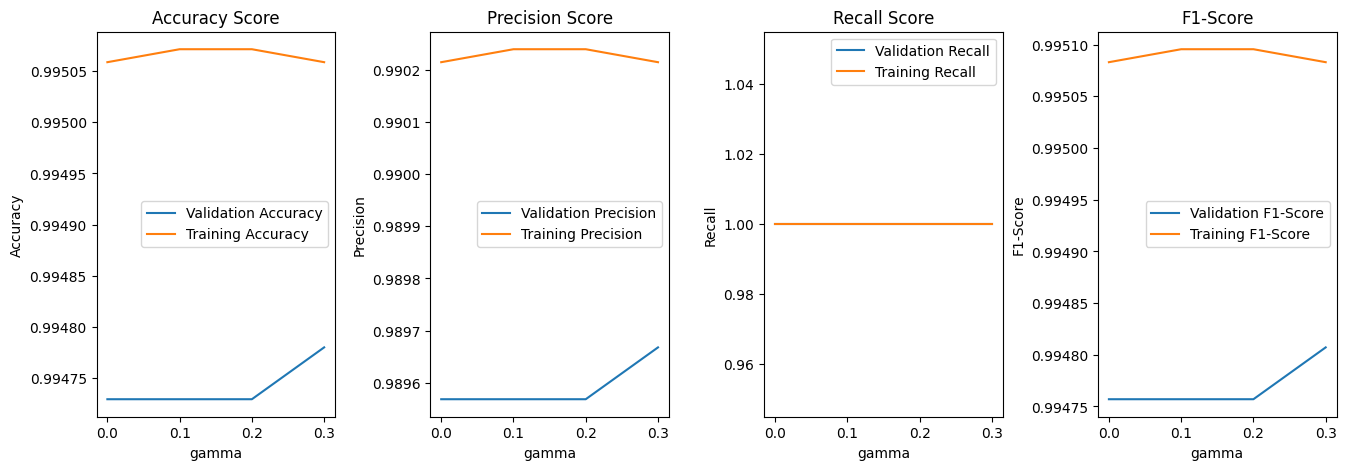

In [50]:
plot_performance(gamma, 'gamma')

### Model after hyperparameter tuning

In [52]:
xgboost_tune = XGBClassifier(random_state=8, objective='binary:logistic', learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth, subsample=subsample, colsample_bytree=colsample_bytree, gamma=0.3)
xgboost_tune.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.3, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=8, ...)

In [54]:
modeling_tune = Modeling(xgboost_tune, X_train, X_val, y_train, y_val, X_test)

                roc-auc score  accuracy score  precision score  recall score   
Training Set         0.999741        0.995059         0.990214           1.0  \
Validation Set       0.999562        0.994780         0.989668           1.0   

                f1 score  
Training Set    0.995083  
Validation Set  0.994807  


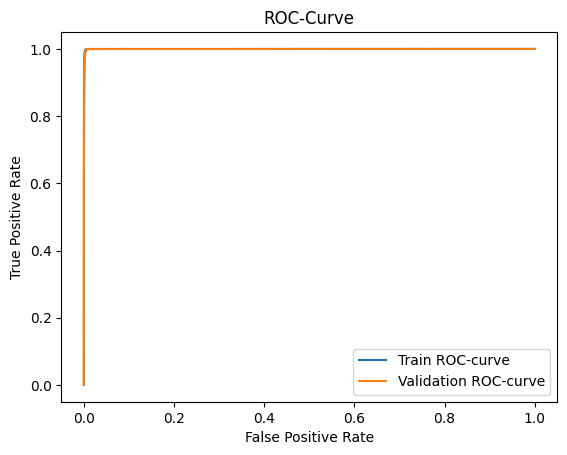

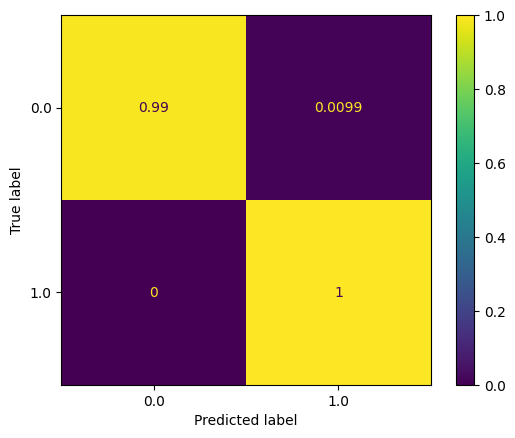

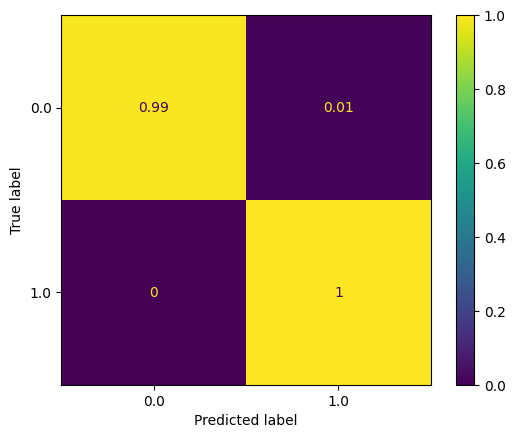

In [55]:
modeling_tune.predict_model()

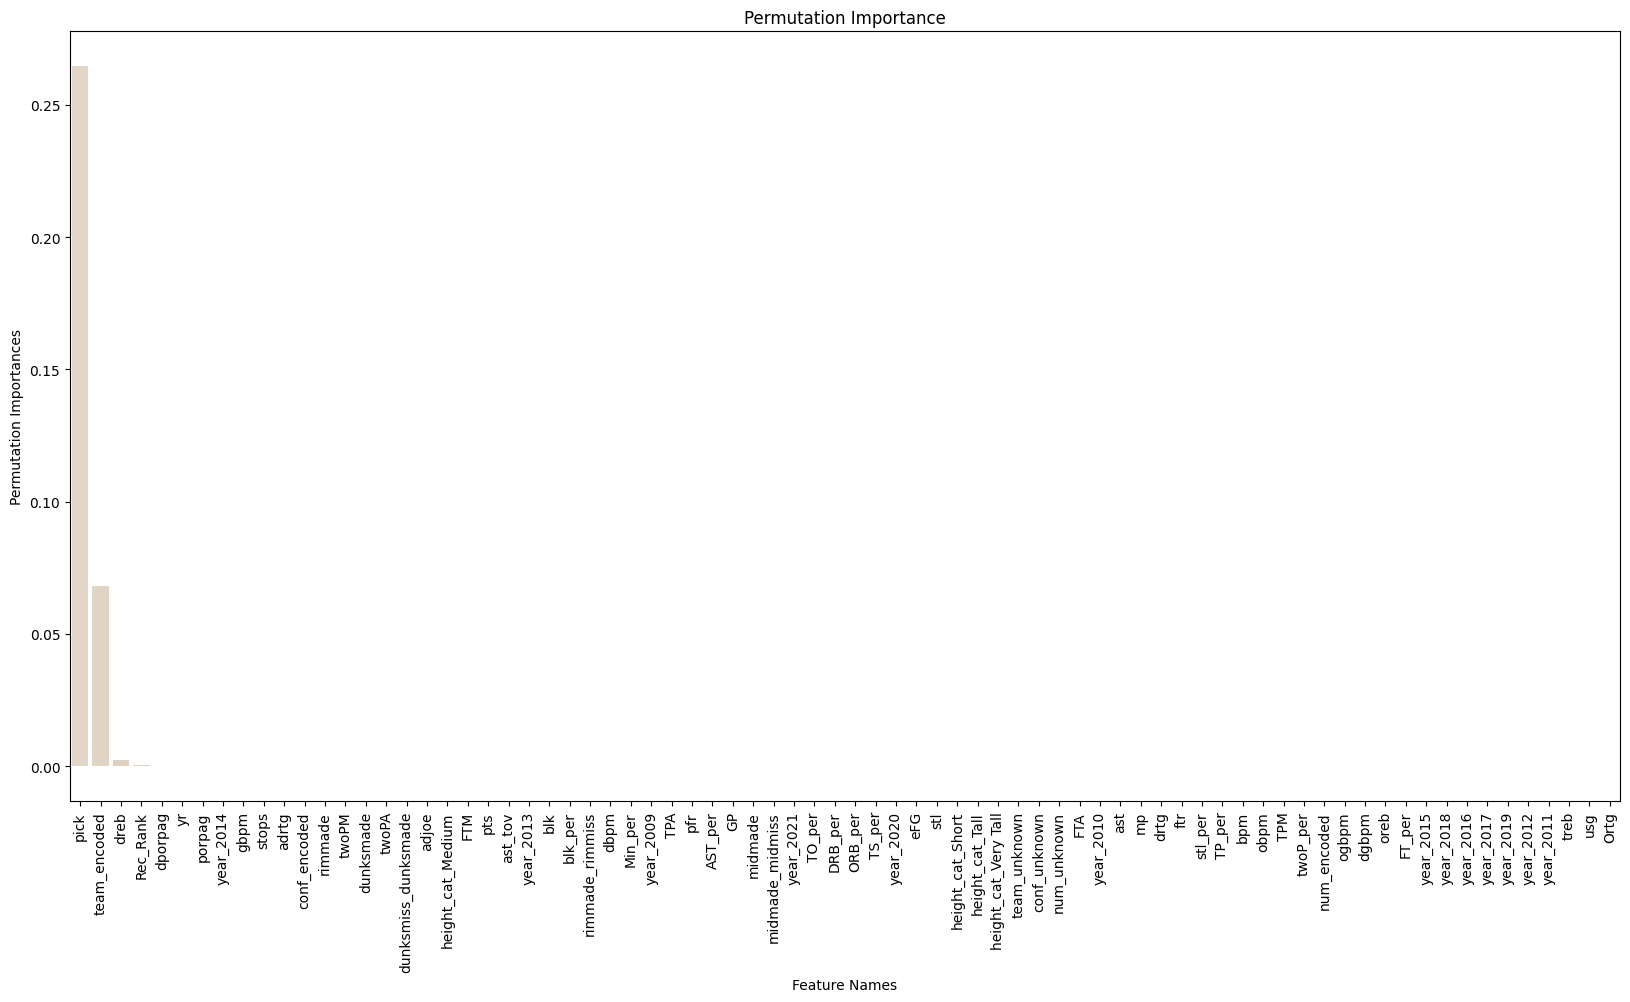

In [56]:
permutation_score_tune = modeling_tune.permutation_importance()

In [58]:
y_test_probs_2 = xgboost_tune.predict_proba(X_test)[:, 1]

In [59]:
submission_2 = submission_file(y_test_probs_2)

In [66]:
submission_2[submission_2['drafted'] >= 0.2].count()

player_id    49
drafted      49
dtype: int64

In [61]:
dump(xgboost_tune, '../models/xgboost_tune.joblib')

['../models/xgboost_tune.joblib']

In [67]:
submission_2.to_csv('../data/submission/submission_2_xgboost_tune.csv', index=False)